## LC Model Search Framework

* Compare 1 season (summer) and 4 temporal steps
* Compare 0 - 1500 training training samples per class in 100 sample increments
* CNN component and RNN components in isolation
* regular CNN+RNN vs conv2dlstm and RNN vs just conv2dLSTM
* Compare to scikit-learn methods using same val and test datasets
* Compare best model across time
    * if major decrease in accuracy then consider training on both 2010 and 2011 data for initial time step
        * consider training on 1999 data to see how it changes the model

In [1]:
import comet_ml
from comet_ml import Experiment
import datetime
import rasterio
import keras
import random
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM, concatenate
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

Using TensorFlow backend.


In [2]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

In [3]:
exp_name = 'fullval_keras_tests'
model_name = 'rcnn'

Assign your specific GPU so we don't overlap

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="0";

Is that GPU and only that GPU visible?

Note that it will always say GPU:0 but you should just see one

In [6]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Ingest Training Labels

Note that these are monster files so be careful how you inspect them, typically you only want to use the `rasterio` windows option

In [7]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')
class_dict = util.indexed_dictionary

Ingest the landsat imagery stacked into yearly seasonal tiles

In [8]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

### Load pixels from shapefiles

In [9]:
train_gdf = gpd.read_file('../shapefiles/train_buffered_points140520.shp')
train_px = []
for index, row in train_gdf.iterrows():
    train_px.append(((row['row'], row['col']), row['tile_name'], row['label']))

random.shuffle(train_px)

len(train_px), train_px[0]

(9000, ((4769, 3166), '028011', 3))

In [9]:
# train_gdf = gpd.read_file('../shapefiles/train_buffered_points140520_valsubset.shp')
# train_px = []

# per_class_count = [0] * 6
# total_per_class_count = [0] * 6

# for index, row in train_gdf.iterrows():
#     if not row['reject']:
#         total_per_class_count[int(row['manual_val'])] = total_per_class_count[int(row['manual_val'])] + 1
#         if per_class_count[int(row['manual_val'])] < 110:
#             per_class_count[int(row['manual_val'])] = per_class_count[int(row['manual_val'])] + 1
#             train_px.append(((row['row'], row['col']), row['tile_name'], row['manual_val']))
    
# random.shuffle(train_px)

# len(train_px), train_px[0]

(660, ((1580, 4357), '028011', 2))

In [10]:
val_gdf = gpd.read_file('../shapefiles/val_buffered_points140520_val.shp')
val_px = []


per_class_count = [0] * 6
total_per_class_count = [0] * 6

for index, row in val_gdf.iterrows():
    if not row['reject']:
        total_per_class_count[int(row['manual_val'])] = total_per_class_count[int(row['manual_val'])] + 1
        if per_class_count[int(row['manual_val'])] < 120:
            per_class_count[int(row['manual_val'])] = per_class_count[int(row['manual_val'])] + 1
            val_px.append(((row['row'], row['col']), row['tile_name'], row['manual_val']))
    
random.shuffle(val_px)

len(val_px), val_px[0]

(720, ((910.0, 4282.0), '028011', 0))

In [11]:
total_per_class_count, per_class_count

([153, 152, 152, 137, 132, 139], [120, 120, 120, 120, 120, 120])

### Create the RNN

In [12]:
def strangeBlock_v4(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = LSTM(units=filters, activation='elu', return_sequences=True) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp

In [14]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel rnn model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    cnn_layer1 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=True)(input_tensor_tile)
    # batch norm
    cnn_layer2 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=False) (cnn_layer1)
    maxpool = MaxPooling2D(pool_size=(2, 2), strides=None, padding='same') (cnn_layer2)
    flatten = Flatten()(maxpool)
    concat = concatenate([final_block, flatten])
    
    # this makes it a RCNN + LSTM
    #denselayer = Dense(64, activation="elu")(concat)
    # this makes it just an RCNN
    denselayer = Dense(64, activation="elu")(flatten)
    # this makes it just an LSTM
    #denselayer = Dense(64, activation="elu")(final_block)
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (denselayer)
    #canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover])
    return model

Start the experiments here:

In [14]:
experiment = Experiment(api_key="rMFbl2RlGxNuyyL37dE7qPSfE",
                        project_name="chronos", workspace="clifgray")

COMET INFO: old comet version (3.1.6) detected. current: 3.1.12 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/clifgray/chronos/16361bc586ca434386b3ed8574c869ae



In [15]:
experiment.add_tag(exp_name + '_' + model_name)

In [15]:
tile_size = 9
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
epochs = 60
batch_size = 25
steps_division_factor = 10

#### This is the simple MLP Model

In [14]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=((tile_size*tile_size*len(tiles['028012'])*7),)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(class_count, activation='softmax'))

model.summary()


model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                90752     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 92,006
Trainable params: 92,006
Non-trainable param

#### This is the simple CNN Model

In [17]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(tile_size,tile_size,7*len(tiles['028012']))))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(class_count, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 7, 7, 32)          10112     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________

#### This makes the RCNN model

In [16]:
model = make_MLT_dense((len(tiles['028012']),7),(len(tiles['028012']),tile_size,tile_size,7), class_count)
model.summary()
model.compile(optimizer=Adam(), loss={'landcover':'categorical_crossentropy'}, metrics={'landcover':['accuracy']}, loss_weights={"landcover":1})

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tile_input (InputLayer)      (None, 5, 9, 9, 7)        0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 5, 7, 7, 64)       163840    
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 5, 5, 64)          295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
_____________________________________________________

train the model in a loop to see impact of training sample count

In [ ]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

# 2000 tiles
#tiles['028012'] = ['20000105', '20000410', '20000816', '20001003', '20001019']
#tiles['029011'] = ['20000222', '20000410', '20000816', '20001003', '20001019']
#tiles['028011'] = ['20000121', '20000410', '20000512', '20000816', '20001019']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

10
0.8528571405581066
20
0.8642857074737549
40
0.8957142744745527
80
0.9057142840964454
100
0.9157142809459141
200
0.9328571366412299
300
0.954285706792559
400
0.9528571388551167
500
0.9528571367263794
600
0.9599999977009637
700
0.9542857089212963
800
0.9628571335758481
900
0.9599999955722264
1000
0.9642857078995023
1100
0.975714276943888
1200
0.967142852289336
1300
0.9699999945504325
1400
0.967142852289336
1500
0.9671428565468106


(0.5, 1)

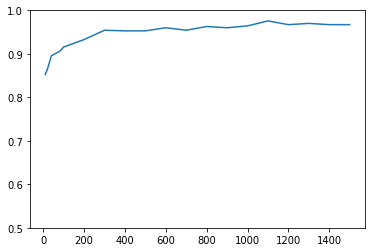

In [28]:
accuracies = []
train_counts = [10, 20, 40, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
epochs = 50
steps_division_factor = 1

tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

for train_count in train_counts:
    print(train_count)

    model = make_MLT_dense((len(tiles['028012']),7),(len(tiles['028012']),tile_size,tile_size,7), class_count)
    model.compile(optimizer=Adam(), loss={'landcover':'categorical_crossentropy'}, metrics={'landcover':['accuracy']}, loss_weights={"landcover":1})

    history = model.fit_generator(generator=tile_gen.tile_generator(train_px[:train_count*6], batch_size, flatten=True, canopy=True), 
                steps_per_epoch=len(train_px[:train_count*6]) // batch_size // steps_division_factor, epochs=epochs, verbose=False,
                validation_data=tile_gen.tile_generator(val_px, batch_size, flatten=True, canopy=True),
                validation_steps=len(val_px) // batch_size) 

    accuracies.append(max(history.history['val_acc']))
    print(max(history.history['val_acc']))

#keras.backend.clear_session()

plt.plot(train_counts, accuracies)
plt.ylim(.5,1)

In [29]:
accuracies

[0.8528571405581066,
 0.8642857074737549,
 0.8957142744745527,
 0.9057142840964454,
 0.9157142809459141,
 0.9328571366412299,
 0.954285706792559,
 0.9528571388551167,
 0.9528571367263794,
 0.9599999977009637,
 0.9542857089212963,
 0.9628571335758481,
 0.9599999955722264,
 0.9642857078995023,
 0.975714276943888,
 0.967142852289336,
 0.9699999945504325,
 0.967142852289336,
 0.9671428565468106]

In [18]:
rcnn_accs

[0.8333333333333334,
 0.8919999897480011,
 0.9226666569709778,
 0.9319999972979228,
 0.935999995470047,
 0.9573333263397217,
 0.9586666564146678,
 0.9639999945958455,
 0.9639999945958455,
 0.9693333307902018,
 0.9666666607062022]

In [44]:
simple_rnn_accs = accuracies
simple_rnn_accs

[0.8013333400090535,
 0.8679999987284343,
 0.8786666691303253,
 0.9079999963442484,
 0.9186666627724965,
 0.9333333293596904,
 0.9279999991257986,
 0.9399999996026357,
 0.9359999934832255,
 0.945333327849706,
 0.935999991496404]

(0.8, 1)

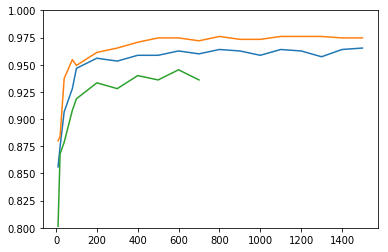

In [45]:
plt.plot(train_counts, simple_mlp_accs)
plt.plot(train_counts, simple_cnn_accs)
plt.plot(train_counts[:11], simple_rnn_accs)
plt.ylim(.80,1)

In [31]:
simple_cnn_accs

[0.8799999992052714,
 0.8839999934037527,
 0.937333329518636,
 0.9546666622161866,
 0.9493333299954733,
 0.9613333284854889,
 0.9653333346048991,
 0.9706666628519695,
 0.9746666610240936,
 0.9746666590372721,
 0.9719999969005585,
 0.9759999930858612,
 0.9733333249886831,
 0.9733333309491475,
 0.9759999970595042,
 0.9759999950726826,
 0.9759999990463257,
 0.9746666610240936,
 0.9746666610240936]

#### Train the Model

In [17]:
filepath = 'model_search/' +  model_name + '--' + exp_name + '.hdf5' #your filepath here
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [18]:
steps_division_factor = 2

In [20]:
# load model if fine-tuning
model = keras.models.load_model('model_search/rcnn--fullval_keras_tests.hdf5')

train_time_start = datetime.datetime.now()

history = model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size, flatten=True, canopy=True), 
                steps_per_epoch=len(train_px) // batch_size // steps_division_factor, epochs=epochs, verbose=1,
                validation_data=tile_gen.tile_generator(val_px, batch_size, flatten=True, canopy=True),
                validation_steps=len(val_px) // batch_size,
                callbacks=callbacks_list) 

train_time_stop = datetime.datetime.now()
training_time = train_time_stop - train_time_start

COMET WARNING: Set model graph by 'keras' ignored; already called. Future attempts are silently ignored.


Epoch 1/60
13/13 [==============================] - 4s 314ms/step - loss: 0.2964 - acc: 0.9200 - val_loss: 0.3117 - val_acc: 0.8900

Epoch 00001: val_acc improved from -inf to 0.89000, saving model to model_search/rcnn_fine--fullval_keras_tests.hdf5
Epoch 2/60
13/13 [==============================] - 2s 186ms/step - loss: 0.2223 - acc: 0.9292 - val_loss: 0.1663 - val_acc: 0.9414

Epoch 00002: val_acc improved from 0.89000 to 0.94143, saving model to model_search/rcnn_fine--fullval_keras_tests.hdf5
Epoch 3/60
13/13 [==============================] - 3s 194ms/step - loss: 0.1439 - acc: 0.9508 - val_loss: 0.1378 - val_acc: 0.9500

Epoch 00003: val_acc improved from 0.94143 to 0.95000, saving model to model_search/rcnn_fine--fullval_keras_tests.hdf5
Epoch 4/60
13/13 [==============================] - 3s 200ms/step - loss: 0.1316 - acc: 0.9600 - val_loss: 0.1472 - val_acc: 0.9514

Epoch 00004: val_acc improved from 0.95000 to 0.95143, saving model to model_search/rcnn_fine--fullval_keras_te

13/13 [==============================] - 3s 195ms/step - loss: 1.1845e-04 - acc: 1.0000 - val_loss: 0.2890 - val_acc: 0.9529

Epoch 00043: val_acc did not improve from 0.95571
Epoch 44/60
13/13 [==============================] - 3s 205ms/step - loss: 1.4020e-04 - acc: 1.0000 - val_loss: 0.2893 - val_acc: 0.9529

Epoch 00044: val_acc did not improve from 0.95571
Epoch 45/60
13/13 [==============================] - 3s 198ms/step - loss: 1.0530e-04 - acc: 1.0000 - val_loss: 0.2838 - val_acc: 0.9529

Epoch 00045: val_acc did not improve from 0.95571
Epoch 46/60
13/13 [==============================] - 3s 199ms/step - loss: 1.2721e-04 - acc: 1.0000 - val_loss: 0.2715 - val_acc: 0.9543

Epoch 00046: val_acc did not improve from 0.95571
Epoch 47/60
13/13 [==============================] - 2s 190ms/step - loss: 9.2820e-05 - acc: 1.0000 - val_loss: 0.2814 - val_acc: 0.9529

Epoch 00047: val_acc did not improve from 0.95571
Epoch 48/60
13/13 [==============================] - 3s 203ms/step - los

dict_keys(['val_acc', 'acc', 'loss', 'val_loss'])


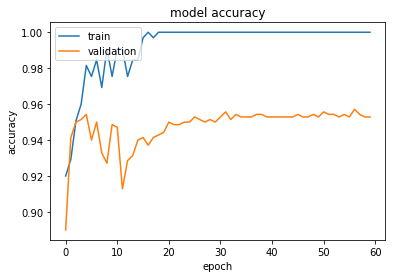

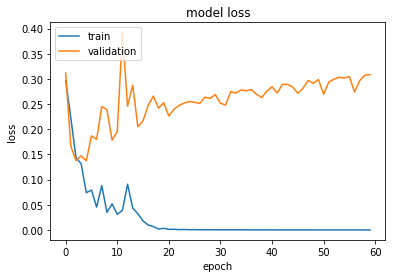

In [21]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
experiment.log_figure(figure=plt, figure_name="model_acc")
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
experiment.log_figure(figure=plt, figure_name="model_loss")
plt.show()

In [51]:
filepath

NameError: name 'filepath' is not defined

In [50]:
model = keras.models.load_model(filepath)

NameError: name 'filepath' is not defined

# Evaluate model

#### change evaluation dataset

In [30]:
dataset_name = '2000val' # '2010val' '2010test' '2000test'

In [40]:
tiles = {}
landsat_datasets = {}
#tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
#tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
#tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

# 2000 tiles
tiles['028012'] = ['20000105', '20000410', '20000816', '20001003', '20001019']
tiles['029011'] = ['20000222', '20000410', '20000816', '20001003', '20001019']
tiles['028011'] = ['20000121', '20000410', '20000512', '20000816', '20001019']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

In [41]:
#val_gdf = gpd.read_file('../shapefiles/val_buffered_points140520_val.shp')
#val_gdf = gpd.read_file('../shapefiles/test_buffered_points140520_val.shp')
val_gdf = gpd.read_file('../shapefiles/test1999_buffered_points140520_val_subset.shp')

val_px = []

per_class_count = [0] * 6
total_per_class_count = [0] * 6

for index, row in val_gdf.iterrows():
    if not row['reject']:
        total_per_class_count[int(row['manual_val'])] = total_per_class_count[int(row['manual_val'])] + 1
        if per_class_count[int(row['manual_val'])] < 100:
            per_class_count[int(row['manual_val'])] = per_class_count[int(row['manual_val'])] + 1
            val_px.append(((row['row'], row['col']), row['tile_name'], row['manual_val']))
    
random.shuffle(val_px)

len(val_px), val_px[0]

tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [42]:
total_per_class_count, per_class_count

([118, 107, 107, 102, 115, 117], [100, 100, 100, 100, 100, 100])

In [43]:
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [44]:
inference_time_start = datetime.datetime.now()

predictions = model.predict_generator(generator = tile_gen.tile_generator(val_px, batch_size=40, flatten=True, canopy=True), steps=len(val_px) //40, verbose=1)

inference_time_stop = datetime.datetime.now()
inference_time = inference_time_stop - inference_time_start

eval_generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True)

15/15 [==============================] - 9s 582ms/step


In [45]:
predictions.shape

(600, 6)

In [46]:
lc_predictions = predictions

In [47]:
lc_lab = np.empty(lc_predictions.shape[0])
#canopy_true = np.empty(canopy_pred.shape)
count = 0
while count < len(lc_predictions):
        image_b, label_b = next(eval_generator)
        #print(label_b.shape)
        #label_b = np.argmax(label_b, axis=-1)
        #print(label_b)
        label_b = np.argmax(label_b['landcover'], axis=-1)
        #canopy_true[count] = label_b['canopy']
        lc_lab[count] = label_b
        count += 1
label_index = lc_lab
pred_index = np.argmax(lc_predictions, axis=-1)

Accuracy is 0.8433333333333334
per_class_acc 0.99
per_class_acc 0.85
per_class_acc 0.56
per_class_acc 0.84
per_class_acc 0.91
per_class_acc 0.91


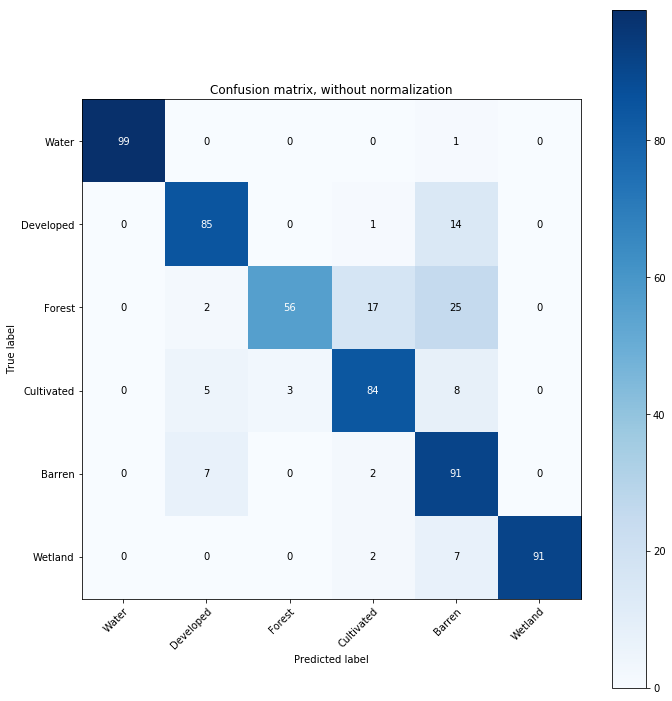

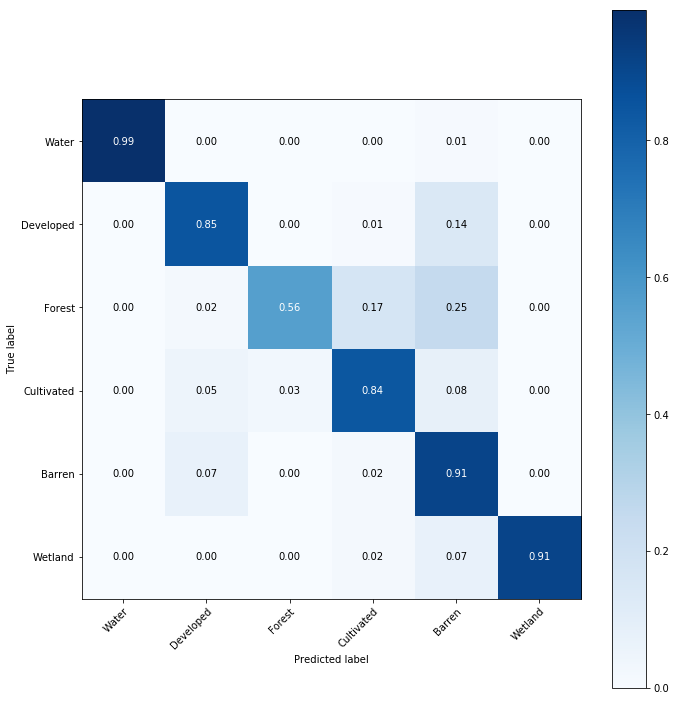

In [49]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
_, users_acc, prod_acc = util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)),
                      class_dict=class_dict)
#experiment.log_figure(figure=plt, figure_name="unnorm_conf_matrix" + dataset_name)
# Plot normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)),
                      class_dict=class_dict,
                      normalize=True,
                          title=" ")
#experiment.log_figure(figure=plt, figure_name="norm_conf_matrix" + dataset_name)
count = 0
per_class_acc = [0] * 6
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        per_class_acc[int(label_index[i])] = per_class_acc[int(label_index[i])] + 1
        count+=1

val_accuracy=count/len(label_index)
class_acc_dict = {}
print("Accuracy is",val_accuracy)
# this is producer's accuracy
for idx, class_correct in enumerate(per_class_acc):
    class_acc_dict[class_dict[idx]] = round(class_correct/(int(len(label_index)/class_count)),4)
    print('per_class_acc', class_correct/(per_class_count[idx]))

Calculate the accuracy per class
Calculate overall accuracy
Add training samples
add epochs
add tile size

In [79]:
import pandas as pd
import seaborn as sns

experiment_df = pd.DataFrame(columns=['exp_name','model_name', 'evaluation_dataset', 'time_steps','train_count','overall_acc', 
                                      'epochs', 'tile_size', 'training_time', 'inference_time',
                                      'water_acc_prod','dev_acc_prod', 'forest_acc_prod', 'cult_acc_prod', 'barren_acc_prod', 'wetland_acc_prod',
                                      'water_acc_user','dev_acc_user', 'forest_acc_user', 'cult_acc_user', 'barren_acc_user', 'wetland_acc_user'])   

In [80]:
experiment_df.loc[len(experiment_df)] = [exp_name, model_name, dataset_name, len(tiles['028012']), len(train_px)/class_count, val_accuracy, 
                                         epochs, tile_size, training_time, inference_time] + list(np.round(prod_acc,3)) + list(np.round(users_acc,3))


In [81]:
experiment_df.tail(5)

,exp_name,model_name,evaluation_dataset,time_steps,train_count,overall_acc,epochs,tile_size,training_time,inference_time,...,forest_acc_prod,cult_acc_prod,barren_acc_prod,wetland_acc_prod,water_acc_user,dev_acc_user,forest_acc_user,cult_acc_user,barren_acc_user,wetland_acc_user
0,fullval_keras_tests,rcnn_fine,2010val,5,110.0,0.954167,60,9,00:02:36.056592,00:00:01.890415,...,0.975,0.958,0.925,0.967,1.0,0.932,0.975,0.935,0.949,0.935


In [82]:
experiment_df.to_csv('model_search/' + model_name + '-' + exp_name + dataset_name + '.csv')

In [83]:
all_exps = pd.read_csv('model_search/' + 'all_model_runs.csv')
all_exps = pd.concat([all_exps,experiment_df], ignore_index=True)
all_exps.to_csv('model_search/' + 'all_model_runs.csv')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


#### Go back and run all of the different datasets before ending the experiment

In [84]:
params = {
    "exp_name":exp_name,
    "model_name":model_name,
    "landsat_tiles":tiles,
    "cnn_tile_size":tile_size,
    "class_dict":class_dict,
    "batch_size":batch_size,
    "steps_division_factor":steps_division_factor,
    "lc_validation_acc":val_accuracy
}
experiment.log_parameters(params)

In [85]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/clifgray/chronos/16361bc586ca434386b3ed8574c869ae
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc [60]                  : (0.9199999983494098, 1.0)
COMET INFO:     batch_acc [122]           : (0.7599999904632568, 1.0)
COMET INFO:     batch_loss [122]          : (2.333734664716758e-05, 0.5073975920677185)
COMET INFO:     epoch_duration [60]       : (2.400969518988859, 4.408462039005826)
COMET INFO:     loss [60]                 : (6.345140403797044e-05, 0.29638200253248215)
COMET INFO:     val_acc [60]              : (0.8899999942098346, 0.957142846924918)
COMET INFO:     val_loss [60]             : (0.1372156340096678, 0.39263787566285047)
COMET INFO:     validate_batch_acc [182]  : (0.7599999904632568, 1.0)
COMET INFO:     validate_

In [79]:
filepath

'model_search/lstm--fullval_keras_tests.hdf5'